In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
!git config --global credential.helper store

In [3]:
# Logging in to hugging face using tokens
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

2024-07-30 01:51:38.556521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 01:51:38.556635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 01:51:38.688975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
from diffusers import DDPMPipeline, DDIMScheduler
image_pipe = DDPMPipeline.from_pretrained('DhruvParth/ddpm-celebahq-256-fineTuned-skin_rash_v2_12epochs').to(device)

# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("DhruvParth/ddpm-celebahq-256-fineTuned-skin_rash_v2_12epochs")
scheduler.set_timesteps(num_inference_steps=40)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

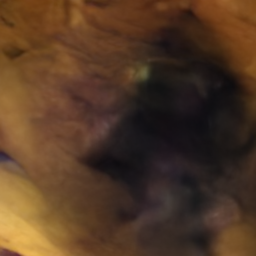

In [18]:
images = image_pipe(num_inference_steps=40).images
images[0]

# Guidance

What do we do if we want some control over the samples generated? For example, say we wanted to bias the generated images to be a specific color. How would we go about that? Enter guidance, a technique for adding additional control to the sampling process.

Step one is to create our conditioning function: some measure (loss) which we’d like to minimize. Here’s one for the color example, which compares the pixels of an image to a target color (by default a sort of light teal) and returns the average error:

In [19]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = torch.tensor(target_color).to(images.device) * 2 - 1  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

Next, we’ll make a modified version of the sampling loop where, at each step, we do the following:

- Create a new version of x that has requires_grad = True
- Calculate the denoised version (x0)
- Feed the predicted x0 through our loss function
- Find the gradient of this loss function with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler, hopefully pushing x in a direction that will lead to lower loss according to our guidance function

There are two variants here that you can explore. In the first, we set requires_grad on x after we get our noise prediction from the UNet, which is more memory efficient (since we don’t have to trace gradients back through the diffusion model) but gives a less accurate gradient. In the second we set requires_grad on x first, then feed it through the UNet and calculate the predicted x0.

0it [00:00, ?it/s]

0 loss: 28.37295913696289
10 loss: 11.354009628295898
20 loss: 10.850414276123047
30 loss: 11.049479484558105


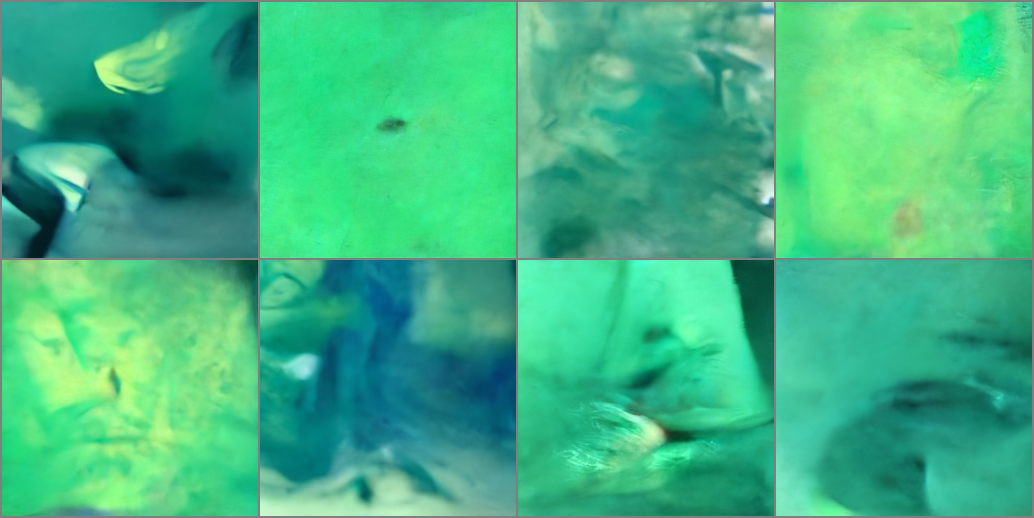

In [ ]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

## Let's make it red

0it [00:00, ?it/s]

0 loss: 27.168739318847656
10 loss: 9.185632705688477
20 loss: 8.36289119720459
30 loss: 8.417901992797852


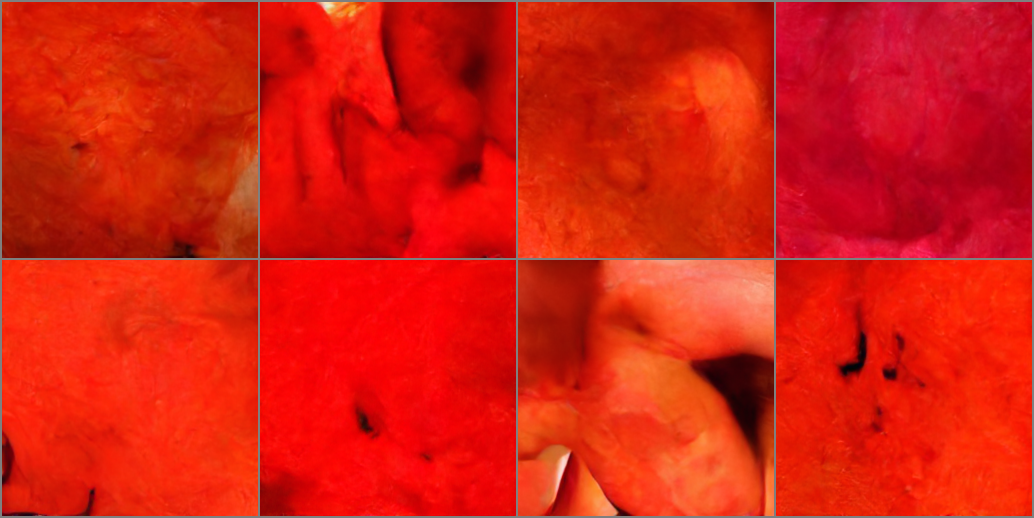

In [22]:
x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0, (1, 0, 0)) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

## Why are we doing an extra modification of x based on gradient in this new method while it does not happen in the normal method ?

**Shouldn't we update the model weights, why is x being modified here ?**

Great question! The extra modification of `x` based on the gradient in the new method is specifically to incorporate guidance into the image generation process. Let's clarify why `x` is being modified rather than updating the model weights, and why this step is necessary.

### Understanding the Difference

1. **Normal Method**:
   - The normal method focuses on training the model to predict the noise in the input image. During training, the model weights are updated based on the loss between the predicted noise and the actual noise.
   - During inference (image generation), the model uses these trained weights to iteratively denoise the input image without modifying the model weights.

2. **New Method with Guidance**:
   - In the new method, the goal is to guide the denoising process to produce images that meet certain desired criteria (e.g., specific color properties). This is achieved by incorporating a custom loss function (`color_loss`).
   - The extra modification of `x` is done to directly influence the generated images based on the guidance provided by the custom loss. This is different from updating the model weights because we are influencing the output of the model at each step to better match the desired criteria.

### Why Modify `x` Instead of Updating Model Weights?

1. **Purpose of Guidance**:
   - The guidance mechanism aims to fine-tune the output of the model at each step, ensuring that the generated images meet specific requirements. This is done by modifying the intermediate outputs (i.e., `x`), rather than changing the underlying model itself.

2. **Direct Influence on Output**:
   - By modifying `x`, we directly influence the image being generated at each timestep. This allows for real-time adjustments to the image generation process, based on the gradients of the custom loss.

3. **Model Consistency**:
   - Updating the model weights would change the model's behavior for all future predictions. In contrast, modifying `x` provides a way to guide the generation process for the current image without altering the model itself, preserving the model's consistency.

### Detailed Explanation of the Process

#### Normal Method (Training)

1. **Forward Pass**:
   - Predict the noise residual: `noise_pred = image_pipe.unet(model_input, t)["sample"]`
   
2. **Loss Calculation**:
   - Calculate the loss between predicted noise and actual noise: `loss = F.mse_loss(noise_pred, noise)`
   
3. **Backward Pass**:
   - Compute gradients and update model weights: `loss.backward()`, `optimizer.step()`, `optimizer.zero_grad()`
   
4. **Step with Scheduler**:
   - Update `x` using the scheduler: `x = scheduler.step(noise_pred, t, x).prev_sample`

#### New Method with Guidance

1. **Forward Pass**:
   - Predict the noise residual: `noise_pred = image_pipe.unet(model_input, t)["sample"]`

2. **Enable Gradient Calculation for `x`**:
   - `x = x.detach().requires_grad_()`
   
3. **Predict Denoised Image**:
   - Get the predicted denoised image: `x0 = scheduler.step(noise_pred, t, x).pred_original_sample`

4. **Custom Loss Calculation**:
   - Calculate custom loss based on the denoised image: `loss = color_loss(x0) * guidance_loss_scale`

5. **Compute Gradient**:
   - Compute gradient of the loss with respect to `x`: `cond_grad = -torch.autograd.grad(loss, x)[0]`

6. **Modify `x`**:
   - Update `x` using the computed gradient to influence the image generation: `x = x.detach() + cond_grad`
   
7. **Step with Scheduler**:
   - Update `x` using the scheduler: `x = scheduler.step(noise_pred, t, x).prev_sample`

### Summary

- **Normal Method**: Focuses on training the model by updating its weights based on the loss. During inference, it uses the trained model to denoise the image iteratively.
- **New Method with Guidance**: Focuses on influencing the generated image at each step by modifying `x` based on a custom loss, providing real-time guidance to meet specific criteria without changing the model itself.

The key difference is that the new method leverages gradient-based updates to `x` to guide the denoising process, ensuring the generated images align with the desired properties defined by the custom loss function. This approach allows for more controlled and fine-tuned image generation.

## So if we are not modifying the models' weights ? Is this not a fine tuning task ?

You're correct. The process described in the new method with guidance is not fine-tuning in the traditional sense. Fine-tuning typically involves updating the model's weights on a new dataset to improve or adjust its performance. Instead, the new method focuses on guiding the inference process to generate images that meet specific criteria.

### Clarification of the New Method

The new method described is a form of **guided inference** rather than fine-tuning. Here's a more detailed explanation:

### Guided Inference Process

1. **Initialize Noisy Image**:
   - Start with a noisy image `x`.

2. **Iterate Over Timesteps**:
   - Loop through the timesteps provided by the scheduler.

3. **Scale Model Input**:
   - Scale the noisy image according to the current timestep.
   ```python
   model_input = scheduler.scale_model_input(x, t)
   ```

4. **Predict Noise Residual**:
   - Use the model to predict the noise component in the scaled noisy image.
   ```python
   noise_pred = image_pipe.unet(model_input, t)["sample"]
   ```

5. **Enable Gradient Calculation for `x`**:
   - Set `x` to `requires_grad=True` to allow gradient calculation.
   ```python
   x = x.detach().requires_grad_()
   ```

6. **Predict Denoised Image**:
   - Use the scheduler to get the predicted denoised image.
   ```python
   x0 = scheduler.step(noise_pred, t, x).pred_original_sample
   ```

7. **Calculate Custom Loss**:
   - Calculate a custom loss function on the predicted denoised image (`x0`).
   ```python
   loss = color_loss(x0) * guidance_loss_scale
   ```

8. **Compute Gradient**:
   - Compute the gradient of the loss with respect to `x`.
   ```python
   cond_grad = -torch.autograd.grad(loss, x)[0]
   ```

9. **Modify `x` Based on Gradient**:
   - Update `x` by adding the computed gradient to push it in the direction that minimizes the loss.
   ```python
   x = x.detach() + cond_grad
   ```

10. **Step with Scheduler**:
    - Update `x` for the next timestep using the scheduler.
    ```python
    x = scheduler.step(noise_pred, t, x).prev_sample
    ```

### Key Differences from Fine-Tuning

1. **Fine-Tuning**:
   - **Objective**: Improve or adjust the model's performance on a new dataset by updating the model's weights.
   - **Process**: Involves training the model with a new dataset, computing gradients, and updating the model parameters (weights) to minimize the loss.
   - **Outcome**: The model itself is changed (fine-tuned) to better fit the new data.

2. **Guided Inference**:
   - **Objective**: Influence the output of the model to meet specific criteria or desired properties without changing the model's weights.
   - **Process**: Involves modifying the input (noisy image `x`) during the inference process based on a custom loss function and its gradients.
   - **Outcome**: The generated images are guided to meet certain criteria, but the model's weights remain unchanged.

### Summary

- **Guided Inference**: This method uses gradient-based modifications to the input (`x`) during the image generation process to meet specific criteria. It does not change the model's weights and is not considered fine-tuning.
- **Fine-Tuning**: Involves training the model on a new dataset and updating the model's weights to improve its performance.

The objective is to guide the image generation process to produce outputs that meet certain requirements (e.g., specific color properties). This is achieved by modifying the input images based on gradients derived from a custom loss function, rather than altering the model's weights.

# CLIP Guidance

Guiding towards a color gives us a little bit of control, but what if we could just type some text describing what we want?

CLIP is a model created by OpenAI that allows us to compare images to text captions. This is extremely powerful, since it allows us to quantify how well an image matches a prompt. And since the process is differentiable, we can use this as a loss function to guide our diffusion model!

We won’t go too much into the details here. The basic approach is as follows:

- Embed the text prompt to get a 512-dimensional CLIP embedding of the text
- For every step in the diffusion model process:
    - Make several variants of the predicted denoised image (having multiple variations gives a cleaner loss signal)
    - For each one, embed the image with CLIP and compare this embedding with the text embedding of the prompt (using a measure called ‘Great Circle Distance Squared’)
- Calculate the gradient of this loss with respect to the current noisy x and use this gradient to modify x before updating it with the scheduler.

In [23]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(5),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)  # Squared Great Circle Distance
    return dists.mean()

100%|████████████████████████████████████████| 354M/354M [00:01<00:00, 230MiB/s]


# Replacing color loss with clip loss

## Testing clip guidance

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step: 0 , Guidance loss: 7.226456165313721
Step: 25 , Guidance loss: 7.37114143371582


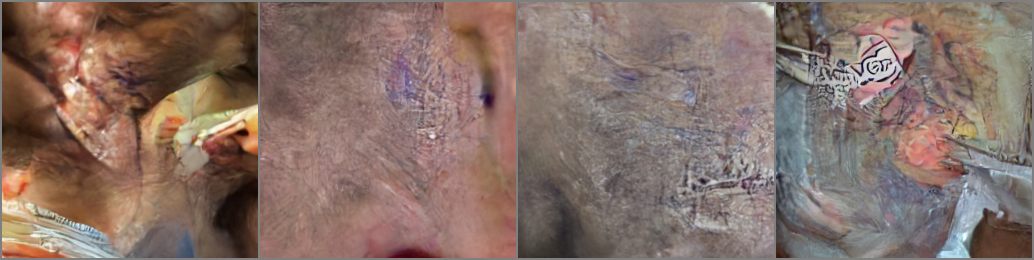

In [24]:
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

### Printing rashes on the chest

0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.089603424072266
Step: 25 , Guidance loss: 6.91538143157959


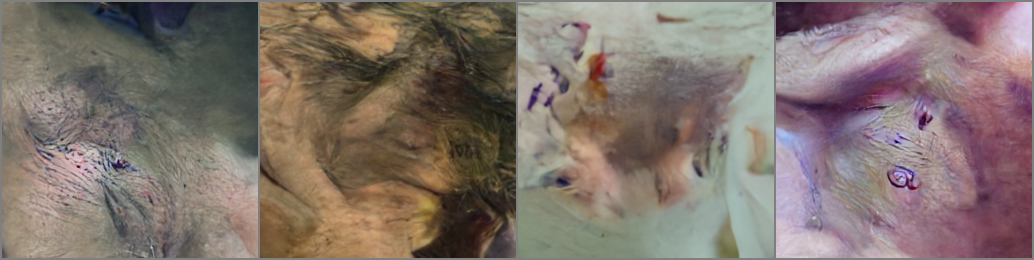

In [25]:
# @markdown applying guidance using CLIP

prompt = "Rashes on the chest"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

### Printing RED rashes

0it [00:00, ?it/s]

Step: 0 , Guidance loss: 6.827795028686523
Step: 25 , Guidance loss: 6.907585144042969


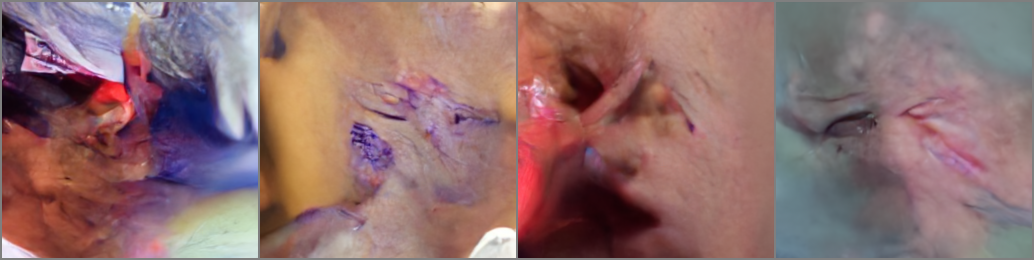

In [27]:
# @markdown applying guidance using CLIP

prompt = "Red color rashes"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

### There are a lot of issues with the current state of the system:

1. The images are nothign like what is being described
2. How does the clip model know to embed the prompt in the right way and how does it know what iamges of rash looks like - we will have to fine tune the model
3. Further we also need to do a better job on fine tuning the image generating diffusion model as well

If we examine the code above we’ll see we're scaling the conditioning gradient by a factor of alpha_bar.sqrt(). There is some theory showing the ‘right’ way to scale these gradients, but in practice this is also something you can experiment with. For some types of guidance, you may want most of the effect concentrated in the early steps, for others (say, a style loss focused on textures) you may prefer that they only kick in towards the end of the generation process. Some possible schedules are shown below:

### Possible guidance scaling schedules

Text(0.5, 1.0, 'Possible guidance scaling schedules')

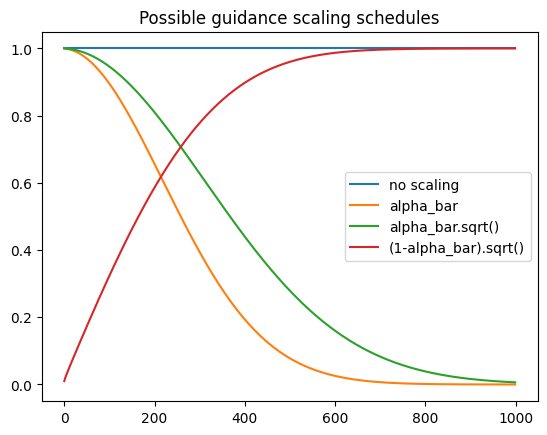

In [26]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot([(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()")
plt.legend()
plt.title("Possible guidance scaling schedules")